Setup

In [8]:
import os

DATA_DIR = os.path.join(os.path.abspath(''), 'tsplib-data')
PROBLEMS_DIR = os.path.join(DATA_DIR, 'problems')
FEATURES_DIR = os.path.join(DATA_DIR, 'npy')
# See the functions dict (line 478) in ./optlearn/optlearn/feature/features.py
# For any feature computation function named compute_fX_edges, you can add fX here
DESIRED_EDGE_FEATURES = ['fa', 'fb', 'fc', 'fd', 'fe', 'ff']
DRAW = False # Display edges with weights and features in build_features

Building features

In [9]:
from optlearn.experiments.build_data import build_features
build_features(FEATURES_DIR, PROBLEMS_DIR, DESIRED_EDGE_FEATURES)


Status:
Directory Status: Checked/Built


Problem 1 of 1 completed

Status:
Directory Status: Checked/Built
Features Status: Checked/Built/Written
Current Problem: N/A


Done! :D


Printing and visualizing features

Features for small_tsp_instance.tsp:
['fa', 'fb', 'fc', 'fd', 'fe', 'ff']


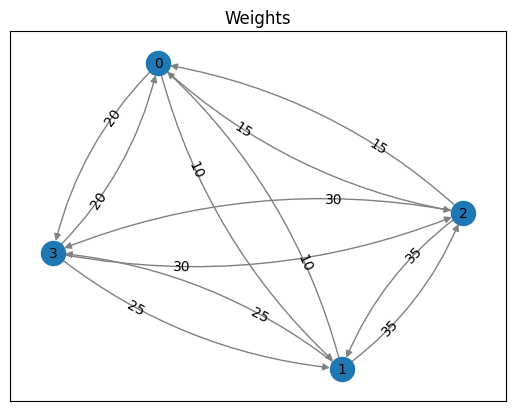

0 (0, 1): [0.30555556 0.52380952 0.30555556 1.         1.         1.        ]
1 (0, 2): [0.44444444 0.76190476 0.44444444 0.6875     0.6875     1.        ]
2 (0, 3): [0.58333333 1.         0.67741935 0.52380952 0.52380952 1.        ]
3 (1, 0): [0.30555556 0.30555556 0.52380952 1.         1.         1.        ]
4 (1, 2): [1.         1.         1.         0.30555556 0.30555556 0.44444444]
5 (1, 3): [0.72222222 0.72222222 0.83870968 0.42307692 0.42307692 0.80769231]
6 (2, 0): [0.44444444 0.44444444 0.76190476 0.6875     1.         0.6875    ]
7 (2, 1): [1.         1.         1.         0.30555556 0.44444444 0.30555556]
8 (2, 3): [0.86111111 0.86111111 1.         0.35483871 0.51612903 0.67741935]
9 (3, 0): [0.58333333 0.67741935 1.         0.52380952 1.         0.52380952]
10 (3, 1): [0.72222222 0.83870968 0.72222222 0.42307692 0.80769231 0.42307692]
11 (3, 2): [0.86111111 1.         0.86111111 0.35483871 0.67741935 0.51612903]


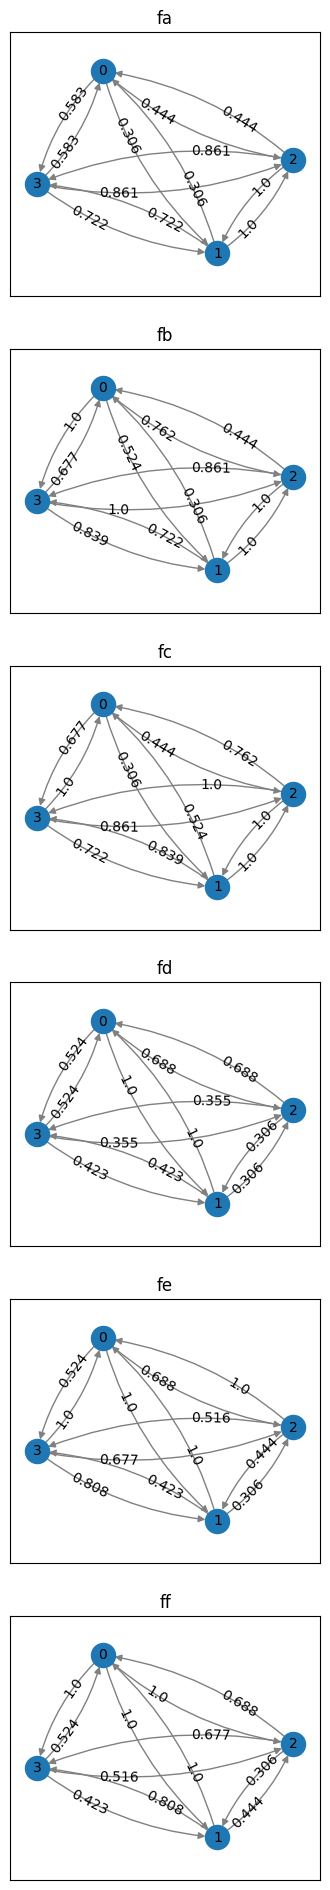

In [10]:
from optlearn.data.data_utils import dataLoader
# FULL_FEATURE_NAMES = [f'compute_{name}_edges' for name in DESIRED_EDGE_FEATURES]
loader = dataLoader([]) # how can we input the data_pairs if we don't have the data yet?

import networkx as nx
from optlearn.graph_utils import get_edges, get_weights
from optlearn.io_utils import optObject

# Note: We're not using optlearn.plotting.plot_graph because it isn't very 
# helpful here - it doesn't show numerical values
# from optlearn.plotting import plot_graph
import matplotlib.pyplot as plt

PYPLOT_WIDTH_INCHES = 4
PYPLOT_HEIGHT_INCHES = 4 * len(DESIRED_EDGE_FEATURES)
ARC_RADIUS = 0.15

def draw_full_graph(ax=None, ):
	nx.draw_networkx_nodes(G, pos, ax=ax)
	nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
	connectionstyle = [f'arc3,rad={ARC_RADIUS}']
	nx.draw_networkx_edges(
		G, pos, edge_color="grey", ax=ax, connectionstyle=connectionstyle)
	nx.draw_networkx_edge_labels(
		G, pos, labels, label_pos=0.3, bbox={"alpha": 0}, ax=ax, connectionstyle=connectionstyle)

for problem_file_name in os.listdir(PROBLEMS_DIR):
	# 2. Prints features
	print(f'Features for {problem_file_name}:')
	print(DESIRED_EDGE_FEATURES)
	feature_file_name = problem_file_name.replace('.tsp', '.npy')
	features_data = loader.load_features([
		os.path.join(FEATURES_DIR, feature, feature_file_name)
		for feature in DESIRED_EDGE_FEATURES])

	# 3. Plots each feature as a separate graph
	problem_file_path = os.path.join(PROBLEMS_DIR, problem_file_name)
	# Returns graph with N(N - 1) edges (all directed edges besides loops)
	G = optObject().read_problem_from_file(problem_file_path).get_graph()
	edges = get_edges(G)
	weights = get_weights(G)
	pos = nx.spring_layout(G)
	
	labels = {}
	for edge_idx, edge in enumerate(edges):
		labels[edge] = weights[edge_idx]
	draw_full_graph()
	plt.title('Weights')
	plt.show()

	# Based on
	# https://networkx.org/documentation/latest/auto_examples/drawing/plot_multigraphs.html#sphx-glr-auto-examples-drawing-plot-multigraphs-py
	fig, axes = plt.subplots(len(DESIRED_EDGE_FEATURES))
	for edge_idx, edge in enumerate(edges):
		print(f'{edge_idx} {edge}: {features_data[edge_idx]}')
	for feature_idx, feature in enumerate(DESIRED_EDGE_FEATURES):
		labels = {}
		for edge_idx, edge in enumerate(edges):
			labels[edge] = round(features_data[edge_idx][feature_idx], 3)
		ax = axes[feature_idx]
		draw_full_graph(ax=ax)
		ax.set_title(feature)
	fig.set_size_inches(PYPLOT_WIDTH_INCHES, PYPLOT_HEIGHT_INCHES)
	plt.show()
